# Data Science Salary Classification  

## Introduction

The below report attempts to build an <b> ordinal logistic regression model </b> capable of multiclass classification of salaries from proffesionals in the datascience field. The original data set can be found on Kaggle under "2019 Kaggle ML & DS Survey Challenge.", and was provided by kaggle for use in their competition of the same name.

The data set first undergoes an initial data cleaning and an exploratory data analysis. Trends in the data are observed, the feature importance is determined, and the data is visualized in order to inform the reader on which features may dictacte the salary outcome. 3 plots are presented to display important trends in salary class distribution based on education level, gender, and job title. The final 4th plot is presented to illustrate correlation of important features to the dependent variable i.e. salary class. Lastly, a lasso regression method is used to reduce model complexity and determine the final features that should be used in the model.

Next, an initial ordinal logistic regression model is constructed to analyze the baseline performance of the model. The <b> ordinal logistic model </b> was unsuccesful at predicting the probabillity of belonging to a salary class. In order to evaluate the effectiveness of multiclass classification a <b> multivariate logistic regression model </b> is subsequently constructed and analyzed. The multiclass logisitic regression model is subjected to 10 fold cross validation and hyperparameter tuning through grid search. The best performing multiclass logistic regression model was found to be the 'newton-cg' solver, with a hyperparamter of 0.05, which acheived a maximum accuracy of ~32%. It is clear that the multiclass classifier was not able to sufficiently predict salary class. Finally to illustrate the capabilities of logisitc regression a <b> one-vs-rest approach </b> was taken, in an attempt to classify the most difficult salary categories. This model was able to achieve an accuracy of above 90% in all cases. 

## Ordinal Logistic Regression Model  

### Library imports 

In [2]:
# import standard libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

# import sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error

# ignore the haters (aka warnings)
warnings.filterwarnings('ignore')
%matplotlib inline

The data is read into the program, and stored in a dataframe.

In [3]:
# read in data
url = 'https://raw.githubusercontent.com/taylrcawte/Salary-Classification/master/Kaggle_Salary.csv'
data = pd.read_csv(url, index_col=0)
data.info()

salData = data.copy()
salData.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12497 entries, 510 to 567
Columns: 247 entries, Q1 to Q10_buckets
dtypes: int64(29), object(218)
memory usage: 23.6+ MB


,Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,...,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
Time from Start to Finish (seconds),,,,,,,,,,,,,,,,,,,,,
510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999"
423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,I do not know,...,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1,14,">250,000"
392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,No (we do not use ML methods),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
470,50-54,Male,-1,France,Master’s degree,Data Scientist,-1,0-49 employees,3-4,"We have well established ML methods (i.e., mod...",...,NaN,AWS Relational Database Service,NaN,NaN,NaN,NaN,NaN,-1,6,"60,000-69,999"


### Data Cleaning and Null Removal

Next the data undergoes an initial data analysis and cleaning phase. First the data is checked for null values visually through the use of a heatplot. The heatplot shows which portions of the data are null (white) and which questions have been responded to (black). 

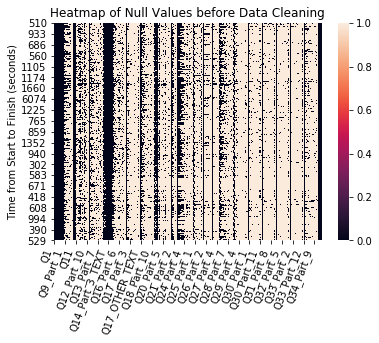

In [4]:
# ----------------------------------------------------------------------------------#
# Initial data cleaning #
# ----------------------------------------------------------------------------------#
plt.figure()
chart = sns.heatmap(salData.isnull())  # heatmap of all null values
chart.set_xticklabels(chart.get_xticklabels(), rotation=70, horizontalalignment='right')
plt.title('Heatmap of Null Values before Data Cleaning')
plt.show()


Columns with less than an 85% response rate were removed, along with features that didn't pertain to the respondant. An 85% response threshold was selected as this was the standard presented in class. Features were removed that did not pertain to the respondant, these features included; features with 'TEXT' in the title, the time it took to complete the survey, and question 19. After these features were removed the remaining rows with 'null' values were removed row-wise.  

In [4]:
salData.dropna(thresh=salData.shape[0] * 0.85, how='all', axis=1, inplace=True)  # drop column with lower than 85% resp
salData.drop(list(salData.filter(regex='TEXT')), axis=1, inplace=True)  # drop any 'OTHER_TEXT' column
salData.drop('Time from Start to Finish (seconds)', axis=1, inplace=True)  # drop completion time
salData.drop('Q19', axis=1, inplace=True)  # drop Q19 because the subject matter does not pertain to respondant
salData.dropna(inplace=True)  # remove remaining rows with null values

salData.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,Q11,Q14,Q15,Q10_Encoded,Q10_buckets
0,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,"30,000-39,999",$0 (USD),"Basic statistical software (Microsoft Excel, G...",1-2 years,3,"30,000-39,999"
1,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...","5,000-7,499","> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",I have never written code,0,"0-9,999"
2,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",20+,I do not know,"250,000-299,999","$10,000-$99,999","Local development environments (RStudio, Jupyt...",1-2 years,14,">250,000"
3,22-24,Male,India,Bachelor’s degree,Other,0-49 employees,0,No (we do not use ML methods),"4,000-4,999",$0 (USD),"Local development environments (RStudio, Jupyt...",< 1 years,0,"0-9,999"
4,50-54,Male,France,Master’s degree,Data Scientist,0-49 employees,3-4,"We have well established ML methods (i.e., mod...","60,000-69,999","$10,000-$99,999","Advanced statistical software (SPSS, SAS, etc.)",20+ years,6,"60,000-69,999"


To ensure that all null values have been removed the heatplot is generated again, this time it should look like one solid colour to indicate no null values. 

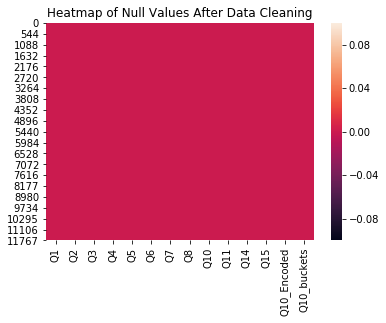

In [5]:
plt.figure()
sns.heatmap(salData.isnull())  # check remaining null values
plt.title('Heatmap of Null Values After Data Cleaning')
plt.show()


### Data Exploration and Feature Selection

The data undergoes an initial data exploration, and the most important features are selected. Below depicts the distribution of salary based on gender, the mean salary based on education level, and finally the mean salary class based on job title. 

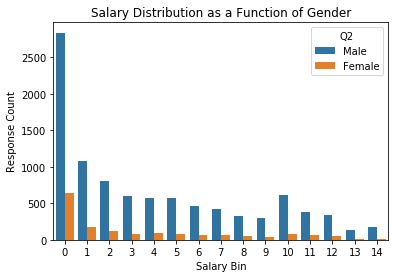

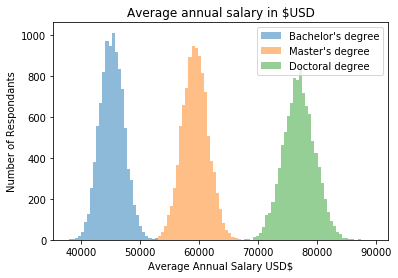

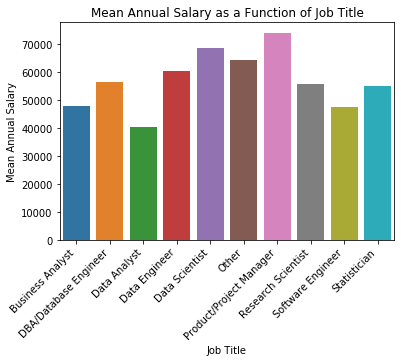

In [6]:
# ----------------------------------------------------------------------------------#
# data exploration #
# ----------------------------------------------------------------------------------#

# show frequency of response as a function of income and gender
plt.figure()
chart = sns.countplot(x='Q10_Encoded', data=salData[~salData['Q2'].isin(['Prefer not to say',
                                                                         'Prefer to self-describe'])], hue='Q2')
plt.title('Salary Distribution as a Function of Gender')
plt.xlabel('Salary Bin')
plt.ylabel('Response Count')
plt.show()

# show average salary distribution as  a function of eduction level
viz = salData[['Q4', 'Q10']]
viz['Q10'] = viz['Q10'].map({'$0-999': 1000, '1,000-1,999': 2000, '2,000-2,999': 3000, '3,000-3,999': 4000,
                             '4,000-4,999': 5000, '5,000-7,499': 7500, '7,500-9,999': 10000, '10,000-14,999': 15000,
                             '15,000-19,999': 20000, '20,000-24,999': 25000, '25,000-29,999': 30000,
                             '30,000-39,999': 40000, '40,000-49,999': 50000, '50,000-59,999': 60000,
                             '60,000-69,999': 70000, '70,000-79,999': 80000, '80,000-89,999': 90000,
                             '90,000-99,999': 100000, '100,000-124,999': 125000, '125,000-149,999': 150000,
                             '150,000-199,999': 200000, '200,000-249,999': 250000, '250,000-299,999': 300000,
                             '300,000-500,000': 400000, '> $500,000': 500000})

bachelorSalVal = np.array(viz[viz['Q4'] == 'Bachelor’s degree']['Q10'].values)
masterSalVal = np.array(viz[viz['Q4'] == 'Master’s degree']['Q10'].values)
docSalVal = np.array(viz[viz['Q4'] == 'Doctoral degree']['Q10'].values)

n = 1000
m = 10000
nBach = len(bachelorSalVal)
nMast = len(masterSalVal)
nDoc = len(docSalVal)

bachAvg = []
mastAvg = []
docAvg = []

for i in range(m):
    bachAvg.append(np.mean(bachelorSalVal[np.random.randint(nBach, size=n)]))
    mastAvg.append(np.mean(masterSalVal[np.random.randint(nMast, size=n)]))
    docAvg.append(np.mean(docSalVal[np.random.randint(nDoc, size=n)]))

x_min = min(np.min(bachAvg), np.min(mastAvg), np.min(docAvg))
x_max = max(np.max(bachAvg), np.max(mastAvg), np.max(docAvg))

x = bachAvg
y = mastAvg
z = docAvg

bins = np.linspace(x_min, x_max, 100)

plt.figure()
plt.hist(x, bins, alpha=0.5, label="Bachelor's degree")
plt.hist(y, bins, alpha=0.5, label="Master's degree")
plt.hist(z, bins, alpha=0.5, label="Doctoral degree")
plt.legend(loc='upper right')
plt.legend(loc='best')
plt.title('Average annual salary in \$USD')
plt.xlabel('Average Annual Salary USD$')
plt.ylabel('Number of Respondants')
plt.show()

# show distributions of salaries as a function of occupation title
viz = pd.concat([salData['Q5'], viz], axis=1)
viz = viz.drop(['Q4'], axis=1)

jobData = viz.groupby(['Q5']).mean()

plt.figure()
chart = sns.barplot(x=jobData.index, y='Q10', data=jobData)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Mean Annual Salary as a Function of Job Title')
plt.xlabel('Job Title')
plt.ylabel('Mean Annual Salary')
plt.show()

Lastly the features are encoded and a correlation plot is used to visualize feature importance. It should be noted that one-hot encoding was also tested (using the pd.get_dummies function) to encoded the feature data, however there was no measurable increase in model performance, for ease of visualization numeric encoding is presented below. 

In [7]:
# encode the features as categorical data
viz2 = salData.copy()
viz2.drop(['Q10', 'Q10_buckets'], axis=1, inplace=True)
viz2 = viz2.astype('category')
vizHeader = list(viz2.columns)
for header in vizHeader:
    viz2[header] = viz2[header].cat.codes
    
viz2.head()

# encodedFeatures = pd.get_dummies(salData.drop('Q10_Encoded', axis=1))
# encodedFeatures.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q11,Q14,Q15,Q10_Encoded
0,1,1,15,3,8,1,0,0,0,1,0,3
1,5,1,20,5,8,4,4,3,5,3,6,0
2,5,1,2,3,5,4,4,0,2,4,0,14
3,1,1,20,0,5,0,0,1,0,4,5,0
4,7,1,15,3,4,0,5,3,2,0,2,6


Text(0.5, 1, 'Correlation Plot Between Features and Salary Bucket')

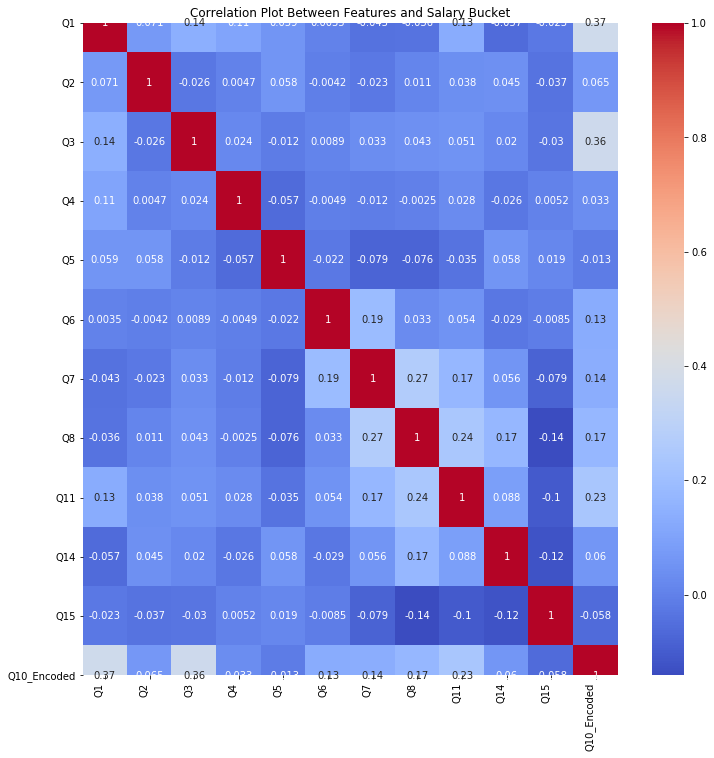

In [8]:
# create a heatmap that shows correlation between remaining variables and salary bucket
plt.figure(figsize=(12, 12))
chart = sns.heatmap(viz2.corr(), cmap='coolwarm', annot=True, square=False)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='right')
chart.set_yticklabels(chart.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.title('Correlation Plot Between Features and Salary Bucket')

It can be seen that the features which show the highest correlation to the target variable (Q10_Encoded i.e. salary bin) are questions 1 and 3 (0.37 and 0.36 correlation factor) while the lowest correlated features are questions 4 and 5 with correlations factors closest to 0. These questions are dropped.

In [9]:
viz2.drop(['Q4', 'Q5'], axis=1, inplace=True)

Now with the partially cleaned and fully encoded data we copy our data to a new variable on which the regression algorithms can be performed. 

In [10]:
# now copy our partially cleaned and fully encoded data to a new variable which we can perform regression on
regData = viz2.copy()

The final step in data cleaning is to use lasso regularized regression to identify any remaining variables which do not have an impact on the target variable. Lasso stands for Least Absolute Shrinkage and Selection Operator. The lasso regression uses shrinkage to transform the data to a central value like the mean, and then perform an L1 regularization which adds a penalty equal to the absolute value of the magnitude of coefficients. Some of the coefficients of the features from the regression can be close to 0, those coefficients have a smaller impact on the target variable than features with larger coefficients. Features with coefficients of 0 were removed. In order help print the results of the lasso regression a helper function is defined.

In [11]:
# ------------------------------------------ helper function ---------------------------------------------- #
def ez_print(coefs, names=None, sort=False):
    if names is None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst, key=lambda x: -np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                      for coef, name in lst)
# -------------------------------------------------------------------------------------------------------- #


# Use Lasso method to further identify variables which do not have importance, variables with coefficients of
# zero are shown to not have an effect on the target variables and are removed #
scaler = StandardScaler()
scaler.fit(regData.drop('Q10_Encoded', axis=1))
scaledData = scaler.transform(regData.drop('Q10_Encoded', axis=1))

lasso = Lasso(alpha=0.3)
lasso.fit(scaledData, regData['Q10_Encoded'])
names = regData.drop('Q10_Encoded', axis=1).columns

print('lasso regression results: ')
print(ez_print(lasso.coef_, names.to_list(), sort=True))

# it can be seen that the coefficients of Q2, Q4, Q14, and Q15 are 0 from the lasso regression and can
# therefore be dropped
regData.drop(['Q2', 'Q14', 'Q15'], axis=1, inplace=True)

lasso regression results: 
1.057 * Q1 + 1.029 * Q3 + 0.395 * Q11 + 0.286 * Q8 + 0.184 * Q6 + 0.1 * Q7 + 0.0 * Q2 + 0.0 * Q14 + -0.0 * Q15


It can be seen from the Lasso Regression that questions 2, 14, and 15 had coefficients of 0 and were therfore removed from the data set. Now we can see our final data set which has been fully cleaned of null values, encoded to numerical values, and had the most important features selected for. The results of the feature selection process indicate that the feature with the highest impact on salary category is age (Q1), followed by country of residence (Q3), use of machine learning at workplace (Q8), and number of employees at current employer (Q6). Surprsingly, education level and gender were deemed unimportant features in the feature selection phase, through both the Lasso regression and the correlation plot. 

The fact that gender and education level were eliminated goes against intuition and the preliminary data analysis until one further considers the data set itself. The collected data was for proffesionals in the data science field, which already requires a high degree of education, so it comports then that further increasing one's education may not be the largest contributing factor to the salary class. With respect to gender, the initial data analysis illustrates the low respondance of women in the field which shows a lack of pairity in employment (not based on bias or discrimination rather just the fact that fewer women are employed in the field). On further contemplation it shows that the spread of salary between both men and women does not have high variance; i.e. the most number of respondants have salaries in the 0th bin. When comparing higher bins there is little difference between them which indicatest that gender will not be able to differentiate between these bins well. 

In [12]:
regData.head()

,Q1,Q3,Q6,Q7,Q8,Q11,Q10_Encoded
0,1,15,1,0,0,0,3
1,5,20,4,4,3,5,0
2,5,2,4,4,0,2,14
3,1,20,0,0,1,0,0
4,7,15,0,5,3,2,6


### Regression Model Implementation 

The fully processed and cleaned data can now be fitted to a logistic regresison model. Because the target variable is ordered (bin0 < bin1, bin1 < bin2 etc.) it is important to use ordinal logistic regression. Ordinal logistic regression accounts for the ordinality of the data by calculating the probability of an index belonging to the target salary class or all lower classes, then subtracting the probability that the data is in the lower classes. An example would be for a given index if the probability of being in salary bin 3 was 0.42, and the previously calculated probabilities of being in bins0-2 were cumulatively 0.31, then the actual probability of being in salary bin 3 is 0.42-0.31 = 0.11. Unfortunately, due to poor accuracy of the logistic regression model in general, an error was encountered that resulted in the higher salary classes having lower probabilities than previous salary classes (i.e. Probability of bin4 < bin3; which should not be then case). This meant then that when the probability of being in a lower salary class was subtracted a negative probability was found. Obviously negative probabilities are not mathematically possible, and furthermore, this error compounded as successive subtractions were conducted (i.e. subtrating a negative number results in a larger positive number). The ultimate result of this error was that the overall probability of greater being in any of the salary bins was greater than 1, an obvious mathematical inaccuracy. The code for the preliminary ordinal logistic regression is presented below however, due to this error the remainder of the project was conducted using multivariate logistic regression.   

In [13]:
salData.drop(['Q2', 'Q4', 'Q5', 'Q14', 'Q15', 'Q10', 'Q10_buckets'], axis=1, inplace=True)
salData2 = salData.astype('category')
encodedFeatures2 = pd.get_dummies(salData.drop('Q10_Encoded', axis=1))
bin2 = salData['Q10_Encoded']
target2 = pd.DataFrame(np.zeros((len(salData.index), 1)), index=salData.index)
target2.rename(columns={0:'targetTrue'}, inplace=True)
regData2 = pd.concat([encodedFeatures2, bin2, target2], axis=1)
allPredicts2 = {}
probs2 = {}
trueTarg2= [] # this is a new variable that will be used to determine whether or not the probabilities being calculated are for 
# the target bin or lower bins, as the algorithm is run the 'trueTarg' value is updated from it's initialized value of 0 to a 
# value of 1 whenever the value of the salary bin matches the value of the iteration, this provides a method of keeping track
# of the bin number and calculating whether an index belongs to the target salary class or lower classes OR the higher classes.
# That is to say that if the value of trueTarg is 1 during iteration 4, the index belongs to bin 4 or 3 or 2 or 1, if the value
# is 0 then the index belongs to one of the higher classes. 

for i in range(max(bin2)):

    regData2['targetTrue'].loc[regData2['Q10_Encoded'] == i] = 1

    x_train, x_test, y_train, y_test = train_test_split(regData2.drop(['Q10_Encoded', 'targetTrue'], axis=1),
                                                        regData2['targetTrue'], test_size=0.2, random_state=101)

    logMod = LogisticRegression(solver='newton-cg', warm_start=True)
    logMod.fit(x_train, y_train)

    probPred2 = logMod.predict_proba(x_test)

    allPredicts2[i] = pd.DataFrame(probPred2, index=x_test.index)

prob0 = allPredicts2[0][1]
prob1 = allPredicts2[1][1]-prob0
prob2 = allPredicts2[2][1]-prob1
prob3 = allPredicts2[3][1]-prob2
salClassProbs = pd.concat([prob0, prob1, prob2, prob3], axis=1)

salClassProbs.columns = list(['prob0', 'prob1', 'prob2', 'prob3'])

Now the previously mentioned error can be checked by checking the header of the salClassProbs dataframe. This dataframe stores the probability that a given index belongs to that salary class as calculated by the logistic regression model. The negative compounding error can be seen in index 1818. For this reason <b> multivariate logistic regression </b> was used.

In [14]:
salClassProbs.head()

,prob0,prob1,prob2,prob3
3739,0.024649,0.043362,0.123615,0.205121
3424,0.427462,0.155723,0.595079,0.190047
7798,0.918278,0.048943,0.931553,0.054062
1818,0.041967,-0.011227,0.047260,-0.006366
4091,0.361033,0.075138,0.466513,0.174177


## Multivariate Logistic Regression

Now that the method of logistic regression has been selected the cleaned data should be double checked and logistic regression for the purpose of salary classification can begin. 

In [15]:
regData.head()

,Q1,Q3,Q6,Q7,Q8,Q11,Q10_Encoded
0,1,15,1,0,0,0,3
1,5,20,4,4,3,5,0
2,5,2,4,4,0,2,14
3,1,20,0,0,1,0,0
4,7,15,0,5,3,2,6


The entire data set is first split into a training and testing set. The test set will be used as a true final test at the end of the script, it contains data that the algorithm will never be exposed to until the very end. The training set here will be used for all training and validation other than the final test step.

In [16]:
regData_xtrain, regData_xtest, regData_ytrain, regData_ytest = train_test_split(regData.drop('Q10_Encoded', axis=1),
                                                                                regData['Q10_Encoded'], test_size=0.3)
x_train, x_test, y_train, y_test = train_test_split(regData_xtrain, regData_ytrain, test_size=0.3)

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

The newly split and scaled data is now fitted to a logistc regression model to perform multivariate analysis. The accuracy of the model is calculated and presented below.

In [17]:
logMod = LogisticRegression(solver='lbfgs', max_iter=200, multi_class='auto')
logMod.fit(x_train, y_train)

predictions = logMod.predict(x_test)
resultsDF = pd.DataFrame({'true': y_test, 'predicted': predictions})
acc = accuracy_score(predictions, y_test)

print('This model got an accuracy of {} % on the test set'.format(round(acc*100, 2)))

This model got an accuracy of 32.56 % on the test set


Now that an intial run has been conducted we can attempt to increase the accuracy of the model by conducting a 10 fold cross validation study. To monitor the algorithm's performance over each fold the accuracies will be presented and the average mean and standard deviation will show the true 10 fold corss validated model performance. Additionally the model performance will be shown by plotting its 'learning curve' over the folds, this will be achieved through the use of a helper function. 

Fold 1: Accuracy: 27.297%
Fold 2: Accuracy: 29.134%
Fold 3: Accuracy: 31.874%
Fold 4: Accuracy: 28.634%
Fold 5: Accuracy: 30.123%
Fold 6: Accuracy: 29.247%
Fold 7: Accuracy: 36.34%
Fold 8: Accuracy: 32.137%
Fold 9: Accuracy: 36.427%
Fold 10: Accuracy: 38.354%
Average Score: 31.957%(3.628%)


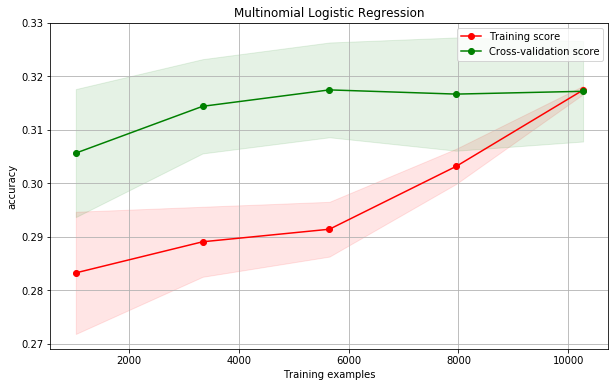

<module 'matplotlib.pyplot' from 'C:\\Users\\Taylr Cawte\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [18]:
# -------------------------------------- helper function ------------------------------------------------#
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring='accuracy'):
    plt.figure(figsize=(10, 6))
    plt.title(title)

    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel(scoring)

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs,
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, \
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, \
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

    return plt
# ----------------------------------------------------------------------------------------------------#
# now that we have done an initial run we will use cross validation to show the true performance of the model on the
# training set #
X = regData.drop('Q10_Encoded', axis=1)
y = regData['Q10_Encoded']
logMod = LogisticRegression(solver='lbfgs', max_iter=200, multi_class='auto')
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

acc2 = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    logMod.fit(X_train, y_train)

    predictions = logMod.predict(X_test)

    acc = accuracy_score(predictions, y_test)

    acc2[np_idx] = acc*100
    np_idx += 1

    print("Fold {}: Accuracy: {}%".format(np_idx, round(acc*100,3)))

print("Average Score: {}%({}%)".format(round(np.mean(acc2), 3), round(np.std(acc2), 3)))

plot_learning_curve(logMod, 'Multinomial Logistic Regression', X, y, cv=10)


### Model Tuning 

Now that the model has been implemented and improved using k-fold cross validation, the model can be further refined using a grid search.

In [19]:
# lets spice things up with a little grid search
logMod = LogisticRegression(max_iter=200, multi_class='auto')
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)
accLog = np.zeros(10)
trainAccLog = np.zeros(10)
testErrorLog =np.zeros(10)
trainErrorLog =np.zeros(10)

bestModel = logMod
bestParams = {}
bestAcc = 0
bestStd = 0
hyperParams = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]
solvers = ['lbfgs', 'newton-cg', 'sag']

biasVar = {}

# for solver in solvers:
#     for C in hyperParams:
#         biasVar[solver] = {}
#         biasVar[solver][C] = {}

for i, solver in enumerate(solvers):
    for j, C in enumerate(hyperParams):

        logMod = LogisticRegression(C=C, solver=solver, multi_class='auto', max_iter=200)
        acc = np.zeros(10)
        np_idx = 0

        for train_idx, test_idx in kfold.split(X):

            x_train, x_test = X.values[train_idx], X.values[test_idx]
            y_train, y_test = y.values[train_idx], y.values[test_idx]

            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            logMod.fit(x_train, y_train)

            predictions = logMod.predict(x_test)
            trainPred = logMod.predict(x_train)

            acc = accuracy_score(y_test, predictions)
            trainAcc = accuracy_score(y_train, trainPred)
            testError = mean_squared_error(y_test, predictions)
            trainError = mean_squared_error(y_train, trainPred)

            accLog[np_idx] = acc*100
            trainAccLog[np_idx] = trainAcc
            testErrorLog[np_idx] = testError
            trainErrorLog[np_idx] = trainError

            np_idx += 1

            # biasVar[solver][C] = {'acclog': accLog, 'trainAccLog': trainAccLog, 'testErrorLog': testErrorLog,
            #                       'trainErrorLog': trainErrorLog}

            if np.mean(accLog) > bestAcc:
                bestParams = {'C': C, 'solver':solver}
                bestAcc = np.mean(accLog)
                bestStd = np.std(accLog)
                # biasVar = {'acclog': accLog, 'trainAccLog': trainAccLog, 'testErrorLog': testErrorLog,
                #            'trainErrorLog': trainErrorLog}
print('Grid search completed')
print(bestParams)
print('best score: {}% ({}%)'.format(round(bestAcc, 3), round(bestStd, 3)))
print('the optimal multinomial log model uses c={}, and a {} solver, and has a cross validation score of {}% with a '
      'standard deviation of {} %'.format(bestParams['C'], bestParams['solver'], round(bestAcc, 3), round(bestStd, 3)))

Grid search completed
{'C': 0.5, 'solver': 'newton-cg'}
best score: 32.0% (3.68%)
the optimal multinomial log model uses c=0.5, and a newton-cg solver, and has a cross validation score of 32.0% with a standard deviation of 3.68 %


### Discussion and Testing 

It can be seen that the best model was determined to be the newton-cg solver with a hyperparameter of 0.05, this will be used to conduct a final test to determine the accuracy of the model on unseen data. 

In [20]:
# now that we have our best parameters we can implement the solver on the unlabelled data
logMod = LogisticRegression(C=bestParams['C'], solver=bestParams['solver'], multi_class='auto')
scaler = StandardScaler()

x_train = regData_xtrain
y_train = regData_ytrain

x_test = regData_xtest

logMod.fit(x_train, y_train)
predictions = logMod.predict(x_test)
acc = accuracy_score(predictions, regData_ytest)
print('the accuracy score for the unseen data (i.e. test data) is {}% using the best solver with the tuned hyperparameter'.format(round(acc*100, 2)))

the accuracy score for the unseen data (i.e. test data) is 31.84% using the best solver with the tuned hyperparameter


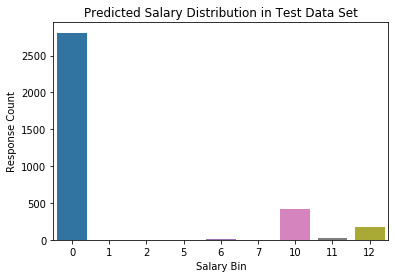

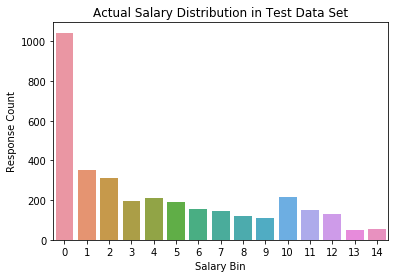

In [21]:
# the predictions are stored in a dataframe and the distribution of salary classes of the test data is presented 
predDf = pd.DataFrame(predictions)
testDf = pd.DataFrame(regData_ytest)

plt.figure()
chart = sns.countplot(x=0, data=predDf)
plt.title('Predicted Salary Distribution in Test Data Set')
plt.xlabel('Salary Bin')
plt.ylabel('Response Count')
plt.show()

plt.figure()
chart = sns.countplot(x='Q10_Encoded', data=testDf)
plt.title('Actual Salary Distribution in Test Data Set')
plt.xlabel('Salary Bin')
plt.ylabel('Response Count')
plt.show()

It can be seen that a majority of the bins with low variance (bin1-bin9, and bin11-bin13) are being classified as being in bins with higher variance i.e. bin1, bin10, and bin14. This indicates that the model is under fitting because it is not able to adequately differentiate between target variables of low variance. Considering that the highest accuracy attained by the logistic regression model after hyperperameter tuning, and a grid search with 10 fold cross validaiton was 32.21% (on the test data) it would suggest that the selected model is not apporpriate for the purpose of salary classification from the provided data set, and cannot be improved further as is. 

The poor classification ability of the logistic regression model is likely due to the fact that logistic regression itself is a binary classifier. With this knowledge it may be possible then to assume that the accuracy could be increased by binarizing the target variables and running an algorithm that treats each salary bin as it's on target variable. For example, consider a given index with given features and a target of salary bin = 4. The binarized target variables to be considered would be bin0-3 = 0, bin4 = 1, and bin5-14 = 0. The model could then be trained based on exactly which features lead to bin_n=1, and may produce a model that is better able to differentiate between bins with low variance. This technique considered a one vs rest logistic regression model and is investigated briefly below. 

In [22]:
x = viz2.drop(['Q2', 'Q14', 'Q15'], axis=1)
y = pd.get_dummies(salData['Q10_Encoded'])

x.head()

,Q1,Q3,Q6,Q7,Q8,Q11,Q10_Encoded
0,1,15,1,0,0,0,3
1,5,20,4,4,3,5,0
2,5,2,4,4,0,2,14
3,1,20,0,0,1,0,0
4,7,15,0,5,3,2,6


In [23]:
y.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


The model will be trained and tested on bins 2, 3, and 4 because these are some of the bins that the first model had trouble identifying. 

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)

In [25]:
logMod2 = LogisticRegression(solver='lbfgs', max_iter=200)
logMod2.fit(x_train, y_train[2])
pred2 = logMod2.predict(x_test)
probAcc2 = accuracy_score(pred2, y_test[2])

logMod3 = LogisticRegression(solver='lbfgs', max_iter=200)
logMod3.fit(x_train, y_train[3])
pred3 = logMod3.predict(x_test)
probAcc3 = accuracy_score(pred3, y_test[3])

logMod4 = LogisticRegression(solver='lbfgs', max_iter=200)
logMod4.fit(x_train, y_train[4])
pred4 = logMod2.predict(x_test)
probAcc4 = accuracy_score(pred2, y_test[4])

print('The accuracy of the one vs rest type logarithmic regression model for the predictions of bins 2, 3, and 4 is {}%, {}%, and {}% respectively'.format(round(probAcc2*100, 2),round(probAcc3*100, 2), round(probAcc4*100, 2)))

The accuracy of the one vs rest type logarithmic regression model for the predictions of bins 2, 3, and 4 is 91.77%, 94.19%, and 93.67% respectively


It can easily be seen that this is a more accurate method of implementation of the logistic regression model and should be further investigated using hyperparameter tuning, and the grid search method to obtain optimal prediction accuracies. It should also be noted that this method does not consider the ordinality of the data however due to the compartively high prediction accuracies it should not matter. 